In [1]:
import pandas as pd

columns = ['lettr', 'x-box', 'y-box', 'width', 'high', 'onpix', 'x-bar', 'y-bar',
           'x2bar', 'y2bar', 'xybar', 'x2ybr', 'xy2br', 'x-ege', 'xegvy', 'y-ege', 'yegvx']
data = pd.read_csv(
    "data/letter-recognition/letter-recognition.data", header=None)
data.columns = columns
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   lettr   20000 non-null  object
 1   x-box   20000 non-null  int64 
 2   y-box   20000 non-null  int64 
 3   width   20000 non-null  int64 
 4   high    20000 non-null  int64 
 5   onpix   20000 non-null  int64 
 6   x-bar   20000 non-null  int64 
 7   y-bar   20000 non-null  int64 
 8   x2bar   20000 non-null  int64 
 9   y2bar   20000 non-null  int64 
 10  xybar   20000 non-null  int64 
 11  x2ybr   20000 non-null  int64 
 12  xy2br   20000 non-null  int64 
 13  x-ege   20000 non-null  int64 
 14  xegvy   20000 non-null  int64 
 15  y-ege   20000 non-null  int64 
 16  yegvx   20000 non-null  int64 
dtypes: int64(16), object(1)
memory usage: 2.6+ MB


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    data.iloc[:, 1:], data.iloc[:, :1], test_size=0.3, random_state=10)

scalar = StandardScaler()
X_train = np.array(scalar.fit_transform(X_train)).T
X_test = np.array(scalar.transform(X_test)).T

y_train = np.array(pd.get_dummies(y_train)).T
y_test = np.array(pd.get_dummies(y_test)).T

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(16, 14000)
(16, 6000)
(26, 14000)
(26, 6000)


In [3]:
import numpy as np
from sklearn.metrics import log_loss, accuracy_score


class Network():
    def __init__(self, num_input_features, num_neurons_in_hidden_layer, hidden_layer_activation, num_output_features, lr):
        self.hidden_layer_activation = hidden_layer_activation
        self.lr = lr
        self.params = {'W1': self.xavier_weights(num_input_features, num_neurons_in_hidden_layer).T,
                       'b1': np.zeros(shape=(num_neurons_in_hidden_layer, 1)),
                       'W2': self.xavier_weights(num_neurons_in_hidden_layer, num_output_features).T,
                       'b2': np.zeros(shape=(num_output_features, 1))}
        self.outs = None
        self.dZ2 = None
        self.grads = None
        self.momentums = {'W1': {'m': 0, 'v': 0},
                          'b1': {'m': 0, 'v': 0},
                          'W2': {'m': 0, 'v': 0},
                          'b2': {'m': 0, 'v': 0}}
        self.epoch = 0

    def xavier_weights(self, fan_in, fan_out):
        return np.random.randn(fan_in, fan_out)/np.sqrt(fan_in)

    def forward(self, X):
        Z1 = self.params["W1"].dot(X) + self.params['b1']
        if self.hidden_layer_activation == 'tanh':
            A1 = np.tanh(Z1)
        elif self.hidden_layer_activation == 'relu':
            A1 = (Z1 > 0)
        Z2 = self.params['W2'].dot(A1) + self.params['b2']
        A2 = np.exp(Z2) / sum(np.exp(Z2))

        self.outs = {'X': np.array(X),
                     'Z1': np.array(Z1),
                     'A1': np.array(A1),
                     'A2': np.array(A2)}

    def cross_entropy_loss(self, y):
        self.dZ2 = self.outs['A2'] - y
        self.dZ2 /= self.dZ2.shape[1]
        train_loss = log_loss(np.argmax(y, axis=0), self.outs['A2'].T)
        return train_loss

    def backward(self):
        dW2 = self.dZ2.dot(self.outs['A1'].T)
        db2 = np.sum(self.dZ2)
        dA1 = self.params['W2'].T.dot(self.dZ2)
        if self.hidden_layer_activation == 'tanh':
            dZ1 = dA1*(1-np.tanh(self.outs['Z1'])**2)
        elif self.hidden_layer_activation == 'relu':
            dZ1 = dA1*(self.outs['Z1'] > 0)
        dW1 = dZ1.dot(self.outs['X'].T)
        db1 = np.sum(dZ1)

        self.grads = {'W1': dW1,
                      'b1': db1,
                      'W2': dW2,
                      'b2': db2}

    def predict(self, X):
        Z1 = self.params["W1"].dot(X) + self.params['b1']
        if self.hidden_layer_activation == 'tanh':
            A1 = np.tanh(Z1)
        elif self.hidden_layer_activation == 'relu':
            A1 = (Z1 > 0)
        Z2 = self.params['W2'].dot(A1) + self.params['b2']
        A2 = np.exp(Z2) / sum(np.exp(Z2))

        return A2

    def adam_optimize(self):
        self.epoch = self.epoch+1
        beta1 = 0.8
        beta2 = 0.88
        epsilon = 1e-7
        for param_name, momentums in self.momentums.items():
            m = beta1*momentums['m'] + (1-beta1)*self.grads[param_name]
            v = beta2*momentums['v'] + \
                (1-beta2)*(self.grads[param_name]**2)
            self.momentums[param_name] = {'m': m, 'v': v}
            m_hat = m/(1-(beta1**self.epoch))
            v_hat = v/(1-(beta2**self.epoch))
            self.params[param_name] = self.params[param_name] - \
                self.lr*(m/(np.sqrt(v)+epsilon))


In [4]:
lrs = [0.001, 0.01, 0.1]
hidden_layer_activations = ['tanh', 'relu']
networks = {}
for lr in lrs:
    for hidden_layer_activation in hidden_layer_activations:
        net = Network(16, 32, hidden_layer_activation, 26, lr)
        networks[net] = {'lr': lr, 'hidden_layer_activation': hidden_layer_activation,
                         'train_loss': [], 'test_loss': [], 'test_accuracy': []}


In [5]:
from tqdm import tqdm

for epoch in tqdm(range(1, 2001), desc="epoch"):
    for network in networks.keys():
        network.forward(X_train)
        train_loss = network.cross_entropy_loss(y_train)

        preds = network.predict(X_test)
        test_loss = log_loss(np.argmax(y_test, axis=0), preds.T)
        test_accuracy = accuracy_score(
            np.argmax(y_test, axis=0), np.argmax(preds, axis=0))

        network.backward()
        network.adam_optimize()

        networks[network]['train_loss'].append(train_loss)
        networks[network]['test_loss'].append(test_loss)
        networks[network]['test_accuracy'].append(test_accuracy)


epoch: 100%|██████████| 2000/2000 [08:43<00:00,  3.82it/s]


In [6]:
import matplotlib.pyplot as plt

net_list = list(networks.keys())

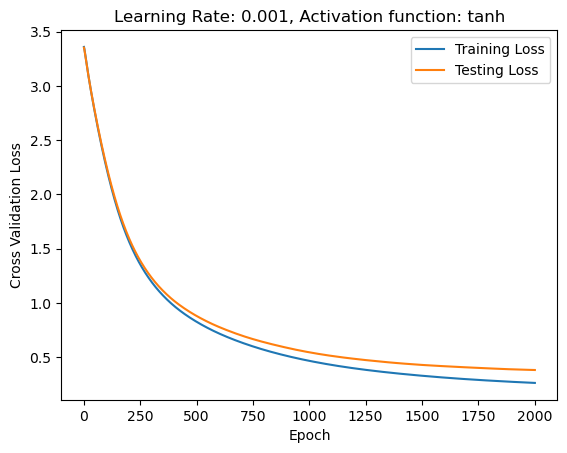

In [7]:
net = net_list[0]
plt.plot(range(1, 2001), networks[net]['train_loss'], label='Training Loss')
plt.plot(range(1, 2001), networks[net]['test_loss'], label='Testing Loss')
plt.xlabel("Epoch")
plt.ylabel("Cross Validation Loss")
plt.title(
    f"Learning Rate: {networks[net]['lr']}, Activation function: {networks[net]['hidden_layer_activation']}")
plt.legend()
plt.show()


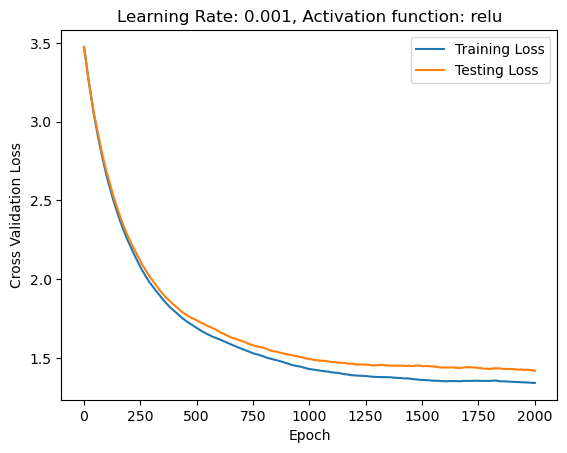

In [8]:
net = net_list[1]
plt.plot(range(1, 2001), networks[net]['train_loss'], label='Training Loss')
plt.plot(range(1, 2001), networks[net]['test_loss'], label='Testing Loss')
plt.xlabel("Epoch")
plt.ylabel("Cross Validation Loss")
plt.title(
    f"Learning Rate: {networks[net]['lr']}, Activation function: {networks[net]['hidden_layer_activation']}")
plt.legend()
plt.show()


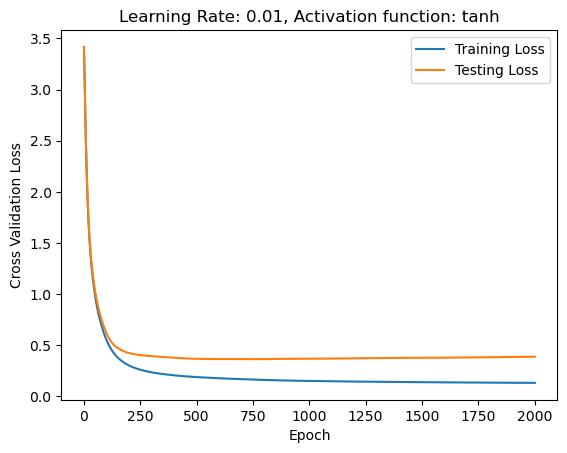

In [9]:
net = net_list[2]
plt.plot(range(1, 2001), networks[net]['train_loss'], label='Training Loss')
plt.plot(range(1, 2001), networks[net]['test_loss'], label='Testing Loss')
plt.xlabel("Epoch")
plt.ylabel("Cross Validation Loss")
plt.title(
    f"Learning Rate: {networks[net]['lr']}, Activation function: {networks[net]['hidden_layer_activation']}")
plt.legend()
plt.show()


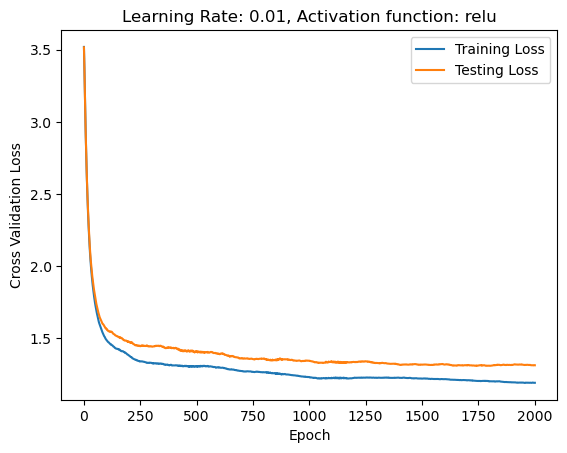

In [10]:
net = net_list[3]
plt.plot(range(1, 2001), networks[net]['train_loss'], label='Training Loss')
plt.plot(range(1, 2001), networks[net]['test_loss'], label='Testing Loss')
plt.xlabel("Epoch")
plt.ylabel("Cross Validation Loss")
plt.title(
    f"Learning Rate: {networks[net]['lr']}, Activation function: {networks[net]['hidden_layer_activation']}")
plt.legend()
plt.show()


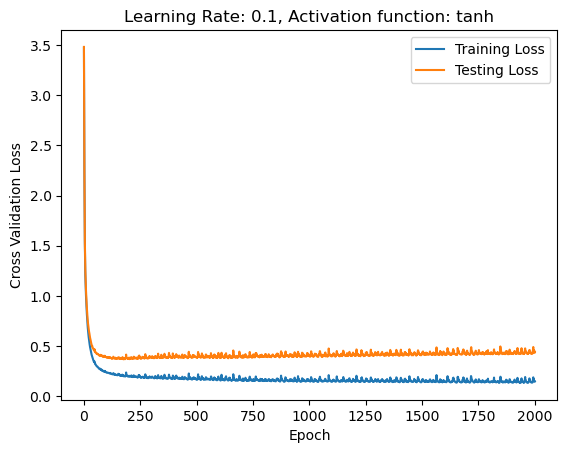

In [11]:
net = net_list[4]
plt.plot(range(1, 2001), networks[net]['train_loss'], label='Training Loss')
plt.plot(range(1, 2001), networks[net]['test_loss'], label='Testing Loss')
plt.xlabel("Epoch")
plt.ylabel("Cross Validation Loss")
plt.title(
    f"Learning Rate: {networks[net]['lr']}, Activation function: {networks[net]['hidden_layer_activation']}")
plt.legend()
plt.show()


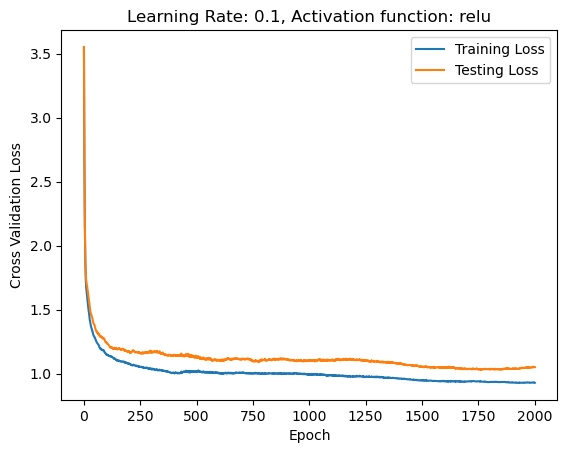

In [12]:
net = net_list[5]
plt.plot(range(1, 2001), networks[net]['train_loss'], label='Training Loss')
plt.plot(range(1, 2001), networks[net]['test_loss'], label='Testing Loss')
plt.xlabel("Epoch")
plt.ylabel("Cross Validation Loss")
plt.title(
    f"Learning Rate: {networks[net]['lr']}, Activation function: {networks[net]['hidden_layer_activation']}")
plt.legend()
plt.show()


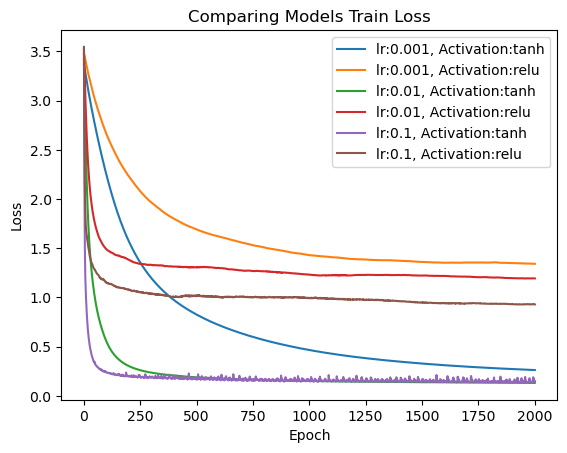

In [14]:
for net in net_list:
    plt.plot(range(1, 2001), networks[net]['train_loss'],
             label=f"lr:{networks[net]['lr']}, Activation:{networks[net]['hidden_layer_activation']}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Comparing Models Train Loss")
plt.legend()
plt.show()


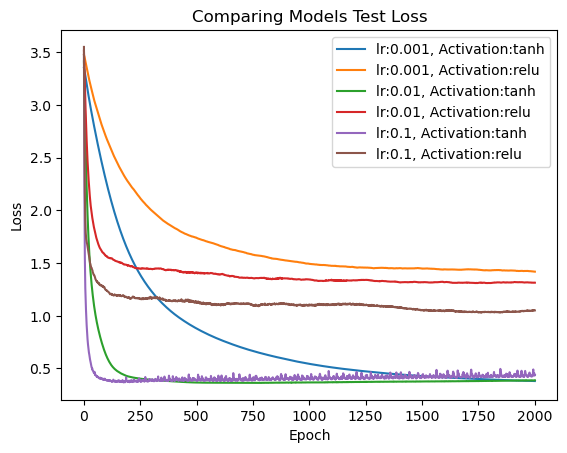

In [15]:
for net in net_list:
    plt.plot(range(1, 2001), networks[net]['test_loss'],
             label=f"lr:{networks[net]['lr']}, Activation:{networks[net]['hidden_layer_activation']}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Comparing Models Test Loss")
plt.legend()
plt.show()

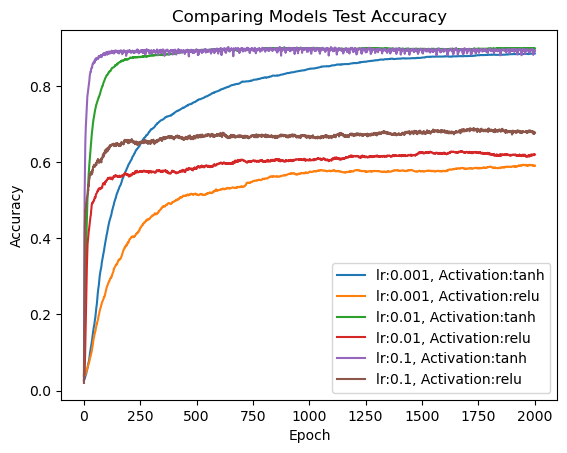

In [13]:
for net in net_list:
    plt.plot(range(1, 2001), networks[net]['test_accuracy'],
             label=f"lr:{networks[net]['lr']}, Activation:{networks[net]['hidden_layer_activation']}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Comparing Models Test Accuracy")
plt.legend()
plt.show()


### Best Model is the one with 0.01 Learning Rate and tanh activation